## Some technical notes about audio parameters

- The sampled signal is obtained in the Linear Pulse Code Modulation (LPCM).
- The signal is stereo (`nchanells=2`), but it is only used the left-side signal.
- It is utilized 16 bits (2 bytes) per sample to encode the audio. The native data type of this data is `int16`, which is capable of storing a [range from](https://www.mathworks.com/help/matlab/ref/audioread.html) `-32768` up to `+32767`.
- The data type is converted to `float` because of the numeric precision and because the floating point in `Python` [is interpreted as](https://docs.python.org/3/library/stdtypes.html#numeric-types-int-float-complex) `double` in `C`, which is convenient.
- The original sampling rate is $44.1\;kHz$. But each recording is downsampled into two different signals, with a sampling rate of $F_s = 22.05\;kHz$.
- The audio dataset comprises five classes (the speeches "avançar", "recuar", "parar", "direita", and "esquerda"), each with 10 recordings, totalizing 50 files. With the downsampling, we have 20 recordings by class. Considering that the `.wav` file is stereo, that is, `nchannel=2`, the number of audio recordings by class is increased to 40. From each of these recordings, it is extracted a discrete-time signal, which is converted to a $N_s$-dimensional vector, being $N_s$ the number of samples of this signal.

## Some notes about the LPC (linear predictive coding) and the Yule-Walker algorithms

- The AR(p) model is implemented for `p=10`, `p=15`, and `p=20`.
- A single recording is divided into 31 frames without overlapping. The number of samples per frames, $N_f$, and the number of samples between each frame, $N_{gap}$, are given by
    $$ N_f = \frac{T_{sig}T_{f_{min}} F_s}{T_{min}} $$
    and
    $$ N_{gap} = \frac{T_{sig} F_s-31N_f}{30},$$
    where $T_{sig}$ is the signal duration, $T_{min}$ is the minimum signal duration of the dataset, and $T_{f_{min}} \triangleq 15\;ms $ is the minimum frame duration. All these variables are defined in seconds.
- The Yule-Walker equation is applied to each of the 31 frames produced from a single audio recording. The final vector is achieved by concatenating all the $31$ coefficients obtained by the Yule-Walker equation, it is given by
$$\mathbf{a}_{p} = \begin{bmatrix}
\mathbf{a}_{p,1}^\mathsf{T} & \mathbf{a}_{p,2}^\mathsf{T} & \cdots & \mathbf{a}_{p,31}^\mathsf{T}
\end{bmatrix}^\mathsf{T} \in \mathbb{R}^{31p},
$$
where $\mathbf{a}_{p,i} \in \mathbb{R}^p$ is the coefficient vector obtained form the $i$-th frame. This procedure is repeated for each of the four signals (channel a and b, samples even and odd) from a single audio recording, for each audio recording.
- For sake of clarity, it  is chosen the normalized (by its l2 norm) version of the autocorrelation function. It makes $r(\tau)$ invariant to the signal energy of the frame.

---

> 1. Carregar os diversos arquivos de áudio e realizar a subamostragem dos sinais de cada canal a fim
de gerar a base de dados de treino e teste.

### Initializing

In [14]:
%reset -f
from numpy import matmul, inf, empty, concatenate, arange, inner, array, sin, pi
from numpy.fft import fft
from statsmodels.regression.linear_model import yule_walker
from scipy.io import wavfile
from scipy.linalg import toeplitz
from math import floor
from numpy.linalg import norm, cond, matrix_rank as rank, inv
from warnings import warn
from os import listdir
from matplotlib import pyplot as plt

# train/test set split
n_train, n_test = 8, 2
# AR(p) model order -> p = 10, 15, 20
all_p = range(10,21,5)
# all coefficients of the AR(p) model. For each command, we have a 8 set of coefficients
all_a = {f'{command}_file{file_number}_p{p}_s{signal}': empty((0,2)) for p in all_p for command in ('avancar', 'esquerda', 'direita', 'parar', 'recuar') for file_number in range(1,11) for signal in ('0a', '0b', '1a', '1b')}

def get_T_min(root_dir):
    T_min = inf
    for file_name in listdir(root_dir):
        F_s, s_n = wavfile.read(root_dir+file_name)
        # signal duration
        T_sig = s_n[:,0].size * (1/F_s)
        if T_sig < T_min:
            T_min = T_sig
    return T_min

# minimum audio duration of the dataset
T_min = get_T_min('./Audio_files_TCC_Jefferson/')
# minimum frame duration, 15ms (user defined)
T_f_min = 15e-3

### LPC and Yule-Walker algorithm

In [7]:
# %reset_selective -f all_a
for p in all_p:
    for command in ('avancar', 'direita', 'esquerda', 'parar', 'recuar'):
        # training set
        for file_number in range(1,n_train+1):
            file_name = f'./Audio_files_TCC_Jefferson/comando_{command}_{file_number:0>2d}.wav'
            # input audio vector, s_n -> [s[0], s[1], ..., s[N_s-1]]
            F_s, s_n = wavfile.read(file_name)
            # Number of samples
            N_s = s_n[:,0].size
            # signal duration
            T_sig = N_s/F_s
            # convert from int16 to float type
            s_n = s_n.astype(float)
            # downsampling: generate s0_n (even samples) and s1_n (odd samples) from s_n
            s0_n, s1_n = s_n[range(0,N_s,2),:], s_n[range(1,N_s,2),:]
            N_s //= 2
            F_s //= 2
            # number of samples per frame
            N_f = floor(T_sig*T_f_min*F_s/T_min)
            # number of samples between each frame (gap)
            N_gap = floor((N_s - 31*N_f)/30)
            # get channel a and chanell b
            s0a_n, s0b_n, s1a_n, s1b_n = s0_n[:,0], s0_n[:,1], s1_n[:,0], s1_n[:,1]

            # for each of the 4 signals from a single recording: channel a and b, samples even and odd
            for s, signal_id in zip((s0a_n, s0b_n, s1a_n, s1b_n), ('0a', '0b', '1a', '1b')):
                # for each frame
                for i, n in enumerate(range(0, N_s+1, N_f)):
                    # ensure that it is get only 31 frames
                    if i == 31: break
                    # s_n0 -> [s[n0], s[n0+1], ..., s[n0+N_f-1]], being n0\in\mathbb{N}
                    s_n0 = s[n+i*N_gap:n+i*N_gap+N_f]
                    # compute the autocorrelation function (normalized version), r_k -> r[k] -> [r[0], r[1], ..., r[p]]
                    r_k = empty(p+1)
                    for k in range(p+1):
                        r_k[k] = inner(s_n0[:N_f-k], s_n0[k:N_f])/norm(s_n0)
                    # autocorrelation matrix
                    # r_k[:p] -> [r[0], r[1], ..., r[p-1]]
                    R = toeplitz(r_k[:p])
                    # autocorrelation vector
                    # r -> [r[1], r[2], ..., r[p]]
                    r = r_k[1:]
                    if rank(R) == R.shape[0]:
                        if cond(R) > 100e3:
                            pass
                            # warn(f'The autocorrelation matrix of the audio {file_name} is ill-conditioned! The results are suspect!')
                        # Yule-Walker equation
                        a = matmul(inv(R), r)
                        # built-in function for comparison purpose
                        a_hat, _ = yule_walker(s_n0, order=p, method='mle')
                        # difference between my awnser and the built-in function
                        delta_a = a - a_hat
                        # save a
                        all_a[f'{command}_file{file_number}_p{p}_s{signal_id}'] = concatenate((all_a[f'{command}_file{file_number}_p{p}_s{signal_id}'], concatenate((a[:,None],delta_a[:,None]), axis=1)))
                    else:
                        pass
                        # warn(f'The autocorrelation matrix of the audio {file_name} is rank-deficient, skip over to the next audio recording.')

/tmp/ipykernel_14454/2902221309.py:46: UserWarning: The autocorrelation matrix of the audio ./Audio_files_TCC_Jefferson/comando_avancar_06.wav is ill-conditioned! The results are suspect!
  warn(f'The autocorrelation matrix of the audio {file_name} is ill-conditioned! The results are suspect!')
/tmp/ipykernel_14454/2902221309.py:46: UserWarning: The autocorrelation matrix of the audio ./Audio_files_TCC_Jefferson/comando_parar_01.wav is ill-conditioned! The results are suspect!
  warn(f'The autocorrelation matrix of the audio {file_name} is ill-conditioned! The results are suspect!')
/tmp/ipykernel_14454/2902221309.py:46: UserWarning: The autocorrelation matrix of the audio ./Audio_files_TCC_Jefferson/comando_parar_03.wav is ill-conditioned! The results are suspect!
  warn(f'The autocorrelation matrix of the audio {file_name} is ill-conditioned! The results are suspect!')
/tmp/ipykernel_14454/2902221309.py:46: UserWarning: The autocorrelation matrix of the audio ./Audio_files_TCC_Jeffer

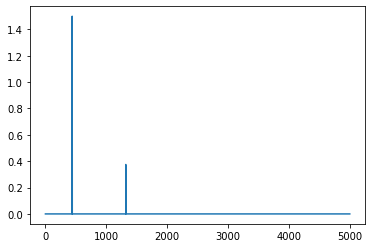

In [19]:
F0=440
Fs=10000
T=3

x = array([sin(2*pi*F0*t) + 0.5*sin(2*pi*3*F0*t) for t in arange(0,T,1/Fs)])

def my_periogram(x, Fs):
    N = x.size
    # Nyquist theorem
    W = Fs/2
    all_f = arange(0,W+Fs/N,Fs/N)

    # two-sided periogram
    p = 1/(N*Fs) * abs(fft(x))**2
    # transform into one-sided
    p = p[0:1+N//2]
    p[1:-1] = 2*p[1:-1]
    
    return p, all_f

X, f = my_periogram(x, Fs)

plt.plot(f, X)